# Discussion on poloidal magnetic field calculation in GTC-FPSDP interface

During the development of GTC-FPSDP interface, we have seen an interesting disagreement between two approaches of calculating the poloidal magnetic field. The following shows the theoretical derivation of both approaches, numerical results, and some discussion.

## 1. Two Formula for calculating $\vec{B}_p$ 

### Contravariant formulism

The contravariant form of magnetic field in an axisymmetry toroidal system is usually given as:

\begin{equation*}
\vec{B} = \nabla \psi \times \nabla(q\theta-\zeta)
\tag{1}
\label{eq:contravariant1}
\end{equation*}

where $\psi = \Psi_{pol}/2\pi$ is a label of poloidal flux, $\psi$, $\theta$ and $\zeta$ form a right-handed coordinate system. $q \equiv \dot{\Psi}_{tor}/\dot{\Psi}_{pol}$ is the safety factor. The over dot denotes derivative respect to $\psi$.

Eq.\ref{eq:contravariant1} can then be written in a more explicit form if we require $\zeta$ to be the symmetry coordinate, so that no equilibrium quantities depend on $\zeta$. As a result, $\nabla \psi \cdot \nabla \zeta=0$, $\nabla \theta \cdot \nabla \zeta=0$, and $\nabla \psi \times \nabla \theta$ is in the direction of $\nabla \zeta$. 

\begin{equation*}
\vec{B} = g(\psi,\theta)\nabla \zeta - \nabla \psi \times \nabla \zeta
\tag{2}
\label{eq:contravariant2}
\end{equation*}

$g(\psi,\theta)$ determines the toroidal magnetic field, while the poloidal field is given by $-\nabla \psi \times \nabla \zeta$ term. 

Eq.\ref{eq:contravariant2} is called a contravariant formulism because $\nabla \zeta \sim \nabla \psi \times \nabla \theta$ and $\nabla \psi \times \nabla \zeta$ are two of the contravariant basis vectors in the $(\psi,\theta,\zeta)$ coordinate system. Vector $\vec{B}$ is thus expressed in the contravariant basis, $\vec{B} = B^\psi \hat{e}_\psi + B^\theta \hat{e}_\theta + B^\zeta \hat{e}_\zeta$.

In GTC, we have information on $\psi(R,Z)$, so $\nabla \psi = \frac{\partial \psi}{\partial R} \hat{R} + \frac{\partial \psi} {\partial Z} \hat{Z}$. and $\nabla \zeta = -\frac{1}{R}\hat{\Phi}$. $(R,\Phi,Z)$ forms the usual right-handed cylindrical coordinate system for tokamaks.

So, a little algebra gives us the expression for $B_R$ and $B_Z$:

\begin{equation*}
B_R = -\frac{1}{R}\frac{\partial \psi}{\partial Z}
\tag{3}
\label{eq:B_R_contravariant}
\end{equation*}

\begin{equation*}
B_Z = \frac{1}{R}\frac{\partial \psi}{\partial R}
\tag{4}
\label{eq:B_Z_contravariant}
\end{equation*}

### Covariant formulism

On the other hand, a covariant expression for vecter $\vec{B}$ is also possible, and formally, it reads

\begin{equation*}
\vec{B} = \delta \nabla \psi + I \nabla \theta + g \nabla \zeta
\tag{5}
\label{eq:covariant}
\end{equation*}

Since magnetic field lines lie on flux surfaces, it is usually assumed that the $\nabla \psi$ component $\delta$ is negligible. So the poloidal field is mainly represented by $I\nabla \theta$.

Similar to contravariant case, in GTC, we know $\theta(R,Z)$, and $I(R,Z)$, we can obtain the poloidal field based on these data. So, $B_R$ and $B_Z$ are given as

\begin{equation*}
B_R = I\frac{\partial \theta}{\partial R}
\tag{6}
\label{eq:B_R_covariant}
\end{equation*}

\begin{equation*}
B_Z = I\frac{\partial \theta}{\partial Z}
\tag{7}
\label{eq:B_Z_covariant}
\end{equation*}

## 2. $\vec{B}_p$ calculated using above two formula

### Contravariant formula looks good

Now, let's calculate poloidal field using the formula we introduced. First, let's try the contravariant formula. In order to do that, we need to calculate the partial derivatives of $\psi$ respect to $R$ and $Z$. The linear interpolator has already done that for us.  

In [1]:
import FPSDP.Plasma.GTC_Profile.GTC_Loader as gtc
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
gtc_path = r'Data/GTC_Outputs/nov6-3/'
timesteps = [1]
grid2d = gtc.Cartesian2D(DownLeft = (-1,1),UpRight = (1,2.2),ResR = 0.01,ResZ = 0.01)
gtcdata = gtc.GTC_Loader(gtc_path,grid2d,timesteps)

2D grid detected.
All time available.


We will use a regular mesh for R and Z, so we can make more intuitive plots.

In [3]:
R1D = gtcdata.grid.R1D
Z1D = gtcdata.grid.Z1D
R2D = gtcdata.grid.R2D
Z2D = gtcdata.grid.Z2D

In [4]:
dpdZ,dpdR = gtcdata.a_eq_interp.gradient(Z2D,R2D)

In [5]:
B_R_contra = -1/R2D * dpdZ
B_Z_contra = 1/R2D * dpdR

Let's take a look at the vector field created by these two components

C:\Users\lei\Anaconda\lib\site-packages\numpy\ma\core.py:790: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)


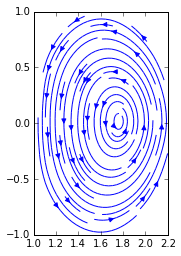

In [6]:
fig = plt.figure()
plt.streamplot(R1D,Z1D,B_R_contra,B_Z_contra)
fig.axes[0].set_aspect(1)

Compare to the flux surfaces $\psi=const$

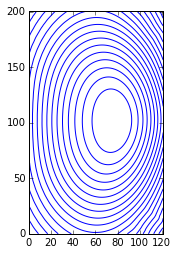

In [7]:
fig = plt.figure()
plt.contour(gtcdata.a_on_grid,20,colors='b')
fig.axes[0].set_aspect(1)

They looks reasonably similar to each other. This means our vector field indeed lies on flux surfaces.

### Covariant formula doesn't look the same!

Now, for covariant formula, we need some extra information that is not available from standard GTC_Loader. Namely, the $I$ function, and $\theta$ interpolator. We need to load them manually from the GTC output files.

In [8]:
import json
gridfile = gtc_path + 'grid_fpsdp.json'
with open(gridfile,'r') as gf:
    gridjson = json.load(gf)
I = np.array(gridjson['ri_gtc'])
I_interp = gtc.linear_interp(gtcdata.triangulation_gtc, I, gtcdata.trifinder_gtc)
I_on_grid = I_interp(Z2D,R2D)

In [9]:
theta_eq = np.array(gridjson['theta_eq'])
theta_interp = gtc.linear_interp(gtcdata.triangulation_eq, theta_eq, gtcdata.trifinder_eq)
dtdZ,dtdR = theta_interp.gradient(Z2D,R2D)

Now, we have all the quantities ready, we can calculate $B_R$ and $B_Z$.

In [10]:
B_R_co = I_on_grid*dtdR
B_Z_co = I_on_grid*dtdZ

Let's see how the vector field looks

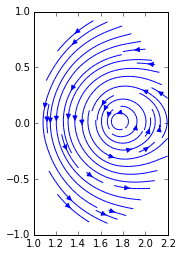

In [11]:
fig = plt.figure()
plt.streamplot(R1D,Z1D,B_R_co,B_Z_co)
fig.axes[0].set_aspect(1)

It doesn't look like the two plots we've got before.

## 3. Discussion on possible reason of the disagreement

Why the two approaches give different results? In order to understand this, let's take a closer look at the derivation and assumptions we made. 

In arriving at the covariant expression for $B_R$ and $B_Z$, we have, at one step, ignored the $\delta \nabla \psi$ term in Eq.\ref{eq:covariant} by vague argument that it is *usually* small. But how small is it in our case? More generally, what is the reason behind this argument, and when is it valid?

If we think about the flux coordinate system we have chosen, the fact that $\psi$ is a flux surface label means that a magnetic field line goes in $\nabla \theta$ and $\nabla \zeta$ directions, but not in $\nabla \psi$ direction. Write it as equation, it means: 

$$\vec{B} \cdot \nabla \psi = 0$$

The contravariant expression naturally satisfy this equation, since it is equivalent to $B^\psi= 0$. 

However, for covariant expression, it's not obvious. Actually, we have:

\begin{equation*}
\delta \nabla \psi \cdot \nabla \psi + I \nabla \theta \cdot \nabla \psi = 0
\end{equation*}

So, in general, when $I\nabla \theta \cdot \nabla \psi \ne 0$, $\delta = -\frac{I\nabla \theta \cdot \nabla \psi}{\nabla \psi \cdot \nabla \psi} \ne 0$. 

In our case, if we draw the constant $\psi$ and constant $\theta$ curves, we can see that they are far from perpendicular to each other at outer midplane. And that's exactly where the covariant formula disagrees the most with the contravariant formula and the magnetic flux surface shapes.

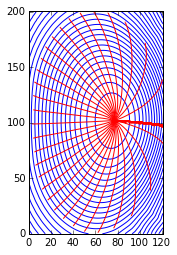

In [12]:
theta_on_grid = theta_interp(Z2D,R2D)
fig = plt.figure()
plt.contour(gtcdata.a_on_grid,30,colors = 'b')
plt.contour(theta_on_grid,36,colors = 'r')
fig.axes[0].set_aspect(1)

## 4. Conclusion

It is clear now that the covariant expression for $B_R$ and $B_Z$ (Eq.\ref{eq:B_R_covariant} and \ref{eq:B_Z_covariant}) are incomplete when our coordinates $\theta$ and $\psi$ are not perpendicular to each other. In this case, $\delta$ needs to be retained if covariant formula is used. On the other hand, the contravariant formula will always satisfy the requirement that field line lies within certain flux surface. 